In [2]:
import pandas as pd
import os
from hcc_cal.commit import Mining
from environment import (
    PROJECTS
)

for project in ["camel"]:
    baseline_data = pd.read_csv(f"../data/dataset/baseline/{project}.csv", index_col=0)
    hcc_data = pd.read_csv(f"../data/dataset/hcc/{project}.csv", index_col=0)
    hcc_data.rename(columns={"ENT": "entropy"}, inplace=True)
    assert(set(baseline_data.index) == set(hcc_data.index))
    data = pd.concat([baseline_data, hcc_data.drop(labels=['buggy', 'repo', 'target', 'project', 'date', 'gap', 'Unnamed: 0'], axis=1)], axis=1)
    # print(data.columns)
    
    for commit_hash in data.index:
        commit = Mining.load("../data/cache", project, commit_hash)
        if commit is None:
            print(f"Commit {commit_hash} not found")
            data.drop(index=commit_hash, inplace=True)
            continue
        methods_len = len(commit.methods_after)
        asts = {}
        will_remove = set()
        for method in commit.methods_after:
            representation = ""
            for path, node in method.ast:
                representation += node.__repr__()
            asts[method.signature] = representation


        for method in commit.methods_before:
            representation = ""
            for path, node in method.ast:
                representation += node.__repr__()
            
            if asts[method.signature] == representation:
                # print(f"https://github.com/apache/{project}/commit/{commit_hash}")
                will_remove.add(method)

        for method in will_remove:
            commit.methods_after.remove(method)
            commit.methods_before.remove(method)

        if len(commit.methods_after) == 0:
            print(f"Empty commit {commit_hash}")
            # Remove commit from cache
            os.remove(f"../data/cache/{project}/{commit_hash}.pkl")
            # Remove commit from data
            data.drop(index=commit_hash, inplace=True)
        elif methods_len != len(commit.methods_after):
            # print(f"Removed {methods_len - len(commit.methods_after)} methods from {commit_hash}")
            Mining.save(commit, "../data/cache")

    data.to_csv(f"../data/dataset/filtered/{project}.csv")
    print(f"Filtered {project}")

            


Not found cache file
Commit 3fdfe19f79229e5dc4aea2e4d110fbe399a21fc7 not found
Not found cache file
Commit 31a517c9c31849ade7417f9c839e0b36bfdb0536 not found
Not found cache file
Commit a901a20ddaca168d82557bbcfcfa35dd4c2349fa not found
Not found cache file
Commit 26b01a308d184e8a250b8e47ff0ccc514a8368ed not found
Not found cache file
Commit 1e394a79fec9c3d7ffe2b8884700b16d7a3bebae not found
Not found cache file
Commit ef5254b7a3cca80b27866dcc77ec2b772e9ec6a9 not found
Not found cache file
Commit 95e90d972498a93d8e0532c9d1eff5d047650063 not found
Not found cache file
Commit 6e2a16b4b227cc7ed38d7619b490a13100e9a501 not found
Not found cache file
Commit 81daf355df79497f5d0dd2da0215dc2c35269850 not found
Not found cache file
Commit 54faa5aa265c3e6c9a44586279e3898a2f80a492 not found
Not found cache file
Commit 2ee4db29dc47386bcf5f8e8b05648c04a3aabfc9 not found
Not found cache file
Commit 36f45ec75db2b22d4ea9f53528e0e8d3e44f5c44 not found
Not found cache file
Commit bc6ed6f91b0d7a5875be1f6a

In [3]:
for project in ["camel"]:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    data["target"] = "not_yet"
    data.to_csv(f"../data/dataset/filtered/{project}.csv")

In [5]:
for project in PROJECTS:

    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    data["LA/LT"] = data["LA"] / data["LT"]
    data["LD/LT"] = data["LD"] / data["LT"]
    data["LT/NF"] = data["LT"] / data["NF"]
    data["NUC/NF"] = data["NUC"] / data["NF"]
    
    data.to_csv(f"../data/dataset/filtered/{project}.csv")

In [4]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np


def auto_spearman(
    X_train,
    correlation_threshold=0.7,
    correlation_method="spearman",
    VIF_threshold=10,
    verbose=False,
):
    """An automated feature selection approach that address collinearity and multicollinearity.
    For more information, please kindly refer to the `paper <https://ieeexplore.ieee.org/document/8530020>`_.

    Original code from `PyExplainer <https://github.com/awsm-research/PyExplainer/blob/master/pyexplainer/pyexplainer_pyexplainer.py>`_.
    """
    X_AS_train = X_train.copy()
    AS_metrics = X_AS_train.columns
    count = 1


    while True:
        corrmat = X_AS_train.corr(method=correlation_method)
        top_corr_features = corrmat.index
        abs_corrmat = abs(corrmat)

        # identify correlated metrics with the correlation threshold of the threshold
        highly_correlated_metrics = (
            (corrmat > correlation_threshold) | (corrmat < -correlation_threshold)
        ) & (corrmat != 1)

        n_correlated_metrics = np.sum(np.sum(highly_correlated_metrics, axis=0))
        if n_correlated_metrics > 0:
            # find the strongest pair-wise correlation
            find_top_corr = pd.melt(abs_corrmat, ignore_index=False)
            find_top_corr.reset_index(inplace=True)
            find_top_corr = find_top_corr[find_top_corr["value"] != 1]
            top_corr_index = find_top_corr["value"].idxmax()
            top_corr_i = find_top_corr.loc[top_corr_index, :]

            # get the 2 correlated metrics with the strongest correlation
            correlated_metric_1 = top_corr_i.iloc[0]
            correlated_metric_2 = top_corr_i.iloc[1]


            # compute their correlation with other metrics outside of the pair
            correlation_with_other_metrics_1 = np.mean(
                abs_corrmat[correlated_metric_1][
                    [
                        i
                        for i in top_corr_features
                        if i not in [correlated_metric_1, correlated_metric_2]
                    ]
                ]
            )
            correlation_with_other_metrics_2 = np.mean(
                abs_corrmat[correlated_metric_2][
                    [
                        i
                        for i in top_corr_features
                        if i not in [correlated_metric_1, correlated_metric_2]
                    ]
                ]
            )
        
            # select the metric that shares the least correlation outside of the pair and exclude the other
            if correlation_with_other_metrics_1 < correlation_with_other_metrics_2:
                exclude_metric = correlated_metric_2
            else:
                exclude_metric = correlated_metric_1
            count = count + 1
            AS_metrics = list(set(AS_metrics) - set([exclude_metric]))
            X_AS_train = X_AS_train[AS_metrics]
        else:
            break

    print("According to Part 1 of AutoSpearman,", AS_metrics, "are selected.")

    # (Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis.
    print(
        "(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis"
    )

    # Prepare a dataframe for VIF
    X_AS_train = add_constant(X_AS_train)
    selected_features = X_AS_train.columns
    count = 1
    while True:
        # Calculate VIF scores
        vif_scores = pd.DataFrame(
            [
                variance_inflation_factor(np.array(X_AS_train.values, dtype=float), i)
                for i in range(X_AS_train.shape[1])
            ],
            index=X_AS_train.columns,
        )
        # Prepare a final dataframe of VIF scores
        vif_scores.reset_index(inplace=True)
        vif_scores.columns = ["Feature", "VIFscore"]
        vif_scores = vif_scores.loc[vif_scores["Feature"] != "const", :]
        vif_scores.sort_values(
            by=["VIFscore"], ascending=False, inplace=True, kind="mergesort"
        )

        # Find features that have their VIF scores of above the threshold
        filtered_vif_scores = vif_scores[vif_scores["VIFscore"] >= VIF_threshold]

        # Terminate when there is no features with the VIF scores of above the threshold
        if len(filtered_vif_scores) == 0:
            break

        # exclude the metric with the highest VIF score
        metric_to_exclude = list(filtered_vif_scores["Feature"].head(1))[0]

        print("> Step", count, "- exclude", str(metric_to_exclude))
        count = count + 1

        selected_features = list(set(selected_features) - set([metric_to_exclude]))

        X_AS_train = X_AS_train.loc[:, selected_features]
    X_AS_train = X_AS_train.loc[:, list(set(X_AS_train.columns) - set(["const"]))]
    print(
        "Finally, according to Part 2 of AutoSpearman,",
        X_AS_train.columns.to_list(),
        "are selected.",
    )

    return X_AS_train

In [12]:
from environment import PROJECTS

HCC_ALL = [
    "HV",
    # "DD",
    "MDNL",
    "NB",
    "EC",
    "NOP",
    "NOGV",
    "NOMT",
    "II",
    "E",
    # "E_HV",
    "DD_HV",
]

BASE_ALL = [
    "NUC", "SEXP", "LT", "Entropy", "EXP", "LA", "LD", "NS", "AGE", "REXP", "ND", "NF"
]
total = []
for project in PROJECTS:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    total.append(data)

total = pd.concat(total)
# total.dropna(inplace=True)
print(len(total))
# X = total.drop(labels=["buggy", "target", "project", "date", "gap"], axis=1)

auto_spearman(total[HCC_ALL])

27195
According to Part 1 of AutoSpearman, ['NOGV', 'MDNL', 'II', 'NOP', 'NB', 'NOMT', 'EC', 'DD_HV', 'HV'] are selected.
(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis
Finally, according to Part 2 of AutoSpearman, ['NOGV', 'MDNL', 'II', 'NOP', 'NB', 'HV', 'EC', 'DD_HV', 'NOMT'] are selected.


,NOGV,MDNL,II,NOP,NB,HV,EC,DD_HV,NOMT
commit_id,,,,,,,,,
8f40a7eeca8772a16e45a15ef424142e4f90e129,1.000000,0.000000,0.032258,0.000000,0.000000,578.154085,0.500000,0.043241,9.0
262a5596d9300b7aded14d550cf8f5ee80d7ac0f,0.000000,0.000000,0.000000,1.000000,0.000000,188.183560,1.000000,0.053020,14.0
507bb1bbabbf9feafb33ac42b9c52ec0f8ebfa39,0.500000,0.000000,0.000000,0.000000,0.000000,209.215050,1.000000,0.043018,13.0
a558fef3745807fc4eb75508cd385798da4b64a5,0.521825,0.000000,0.000000,1.000000,0.000000,170.419579,1.000000,0.059517,14.5
73165063467db865c26ee256210dabcb97edd5e1,0.166667,0.000000,0.000000,1.000000,0.000000,223.479713,1.000000,0.053696,11.0
...,...,...,...,...,...,...,...,...,...
6ed0330129439a953bc81fb3ae4324d84152b847,0.231481,1.333333,0.000000,0.000000,0.333333,750.619146,0.371670,0.027819,21.0
250f4a0eda21149efdc32cee5a125ac27c4383ab,0.000000,0.000000,0.000000,2.000000,0.000000,162.534967,0.800000,0.024610,15.0
20571410eaf1776b532ea686be464f0b2a831813,0.575397,1.000000,0.000000,0.666667,0.000000,372.066178,0.821429,0.067062,18.0


In [32]:
# Plot each feature distribution
import matplotlib.pyplot as plt
import seaborn as sns

BASE_FEATURES = ['NUC', 'NDEV', 'SEXP', 'LT', 'EXP', 'ENT', 'LA', 'LD', 'AGE']
HCC_FEATURES = ['NP', 'REC', 'ENT_V', 'RII', 'MDNL', 'NB', 'NTM', 'TS', 'DD_V', 'RG']
FEATURES = BASE_FEATURES + HCC_FEATURES

total = []
for project in PROJECTS:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    total.append(data)

total = pd.concat(total)
print(len(total))
print(len(total))

27195
27195


In [ ]:
#  log transformation
import numpy as np
for feature in FEATURES:
    total[feature] = np.log1p(total[feature])
    plt.figure()
    sns.histplot(total[feature])
    plt.title(feature)
    plt.show()


In [33]:

BASE_FEATURES = ['NUC', 'NDEV', 'SEXP', 'LT', 'EXP', 'ENT', 'LA', 'LD', 'AGE']
HCC_FEATURES = ['NP', 'REC', 'ENT_V', 'RII', 'MDNL', 'NB', 'NTM', 'TS', 'DD_V', 'RG']
FEATURES = BASE_FEATURES + HCC_FEATURES
total = []
for project in PROJECTS:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    total.append(data)

total = pd.concat(total)

variables_to_log_transform = ['NUC', 'NDEV', 'NP', 'NUC', 'RII', 'SEXP', 'TS', 'LT', 'EXP', 'ENT', 'LA', 'LD', 'AGE', 'ENT_V', 'NB']
for feature in variables_to_log_transform:
    total[feature] = np.log1p(total[feature])

total.to_csv("../data/dataset/to_preprocess.csv")

In [34]:
print(len(total))

27195


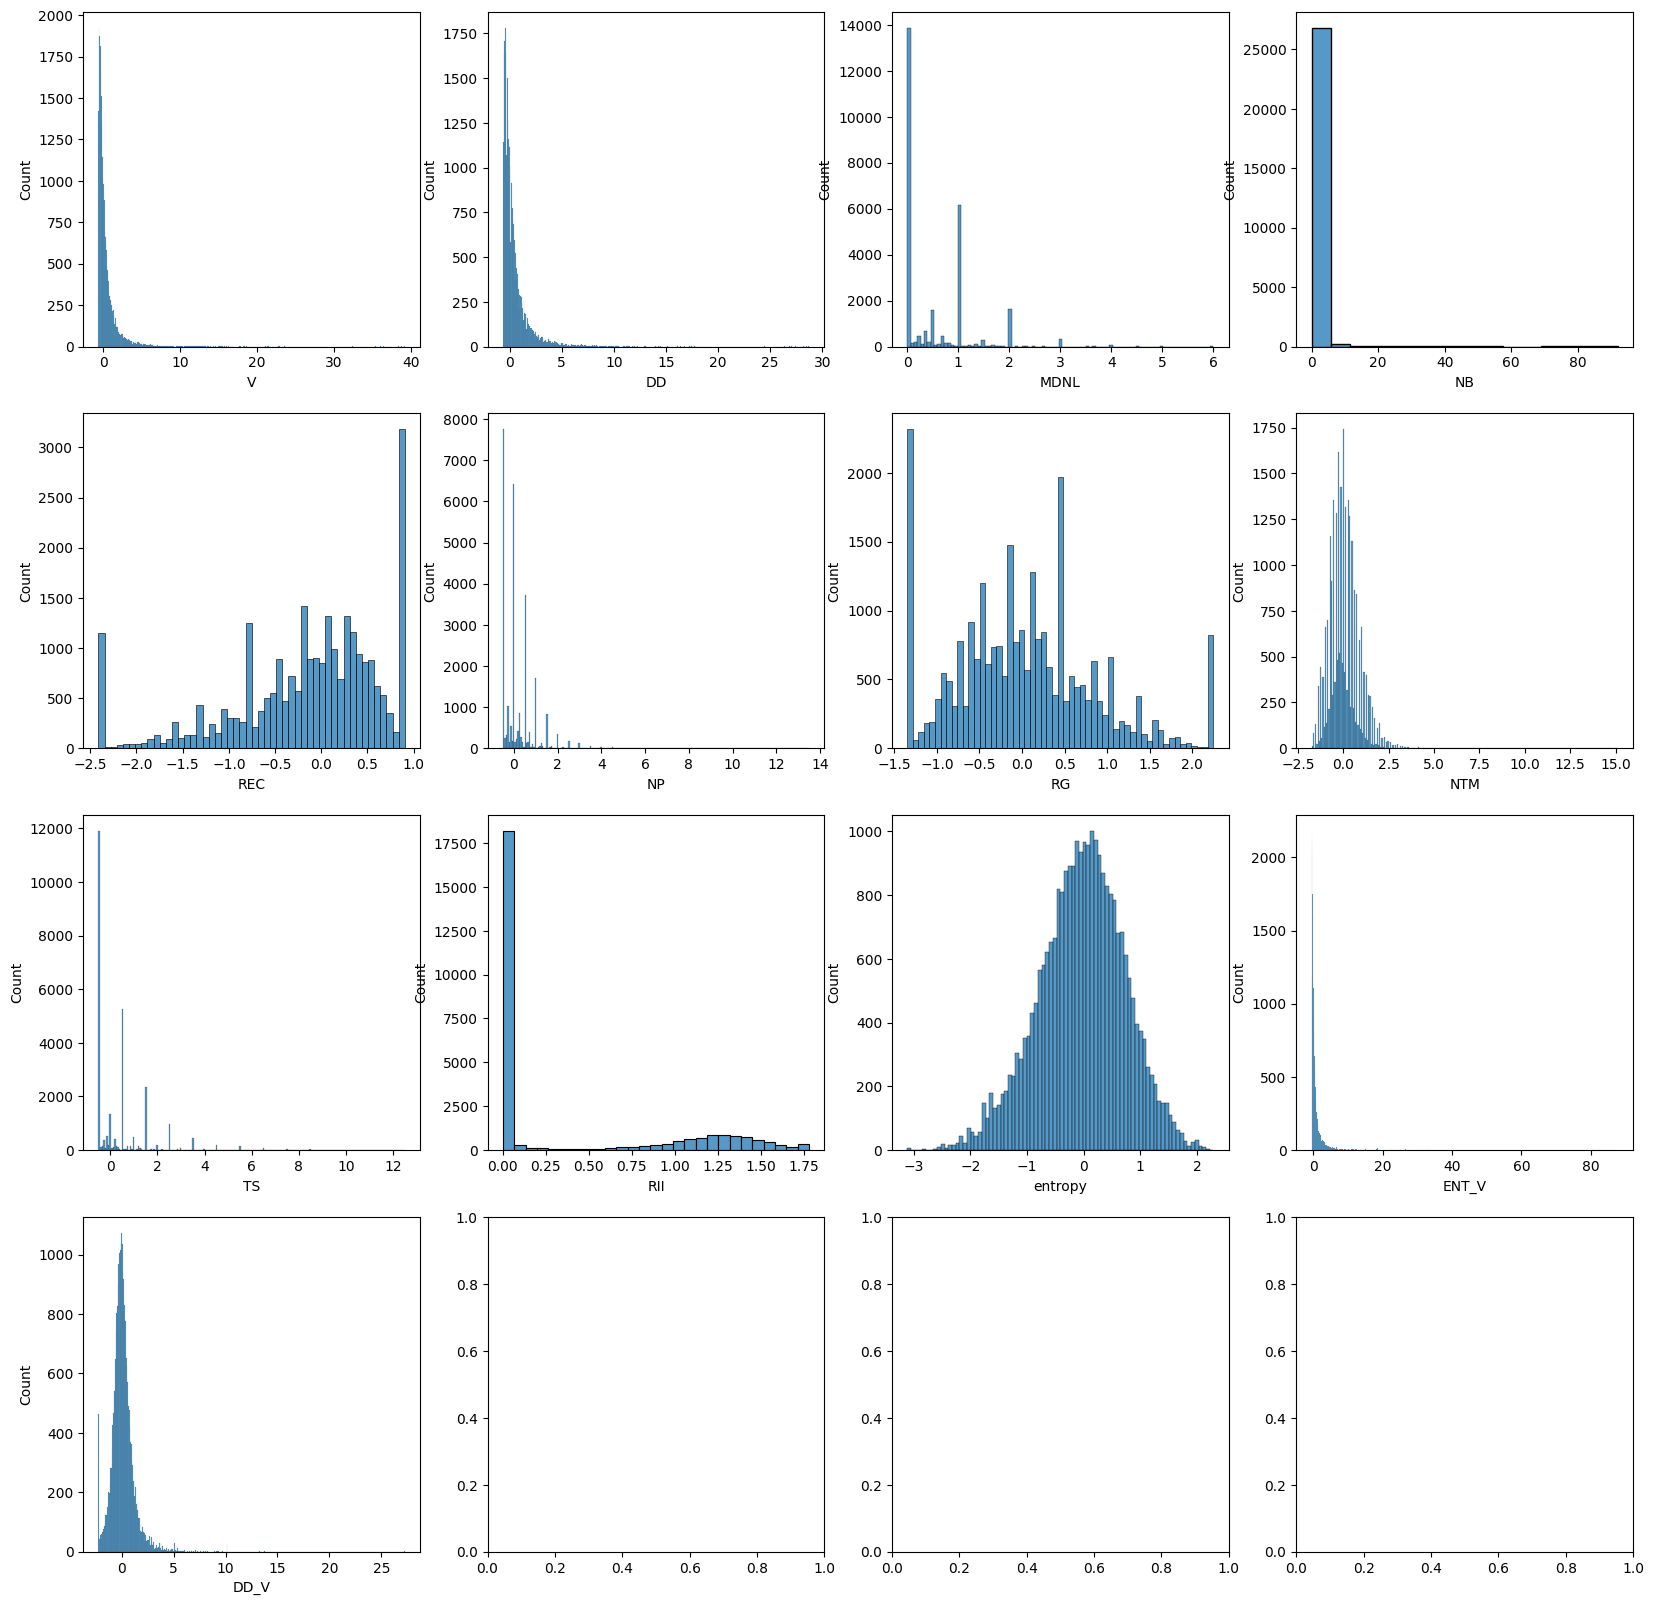

In [54]:
total = []
for project in PROJECTS:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    total.append(data)

total = pd.concat(total)

# Plot each feature distribution
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

HCC_ALL = [
    "V",
    "DD",
    "MDNL",
    "NB",
    "REC",
    "NP",
    "RG",
    "NTM",
    "TS",
    "RII",
    "entropy",
    "ENT_V",
    "DD_V",
]

BASE_ALL = [
    "NUC", "SEXP", "LT", "ENT", "EXP", "LA", "LD", "NS", "AGE", "LA/LT", "LD/LT", "LT/NF", "NUC/NF", "REXP", "ND", "NF"
]


figura, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(HCC_ALL):
    # Remove outliers
    # total = total[total[feature] < total[feature].quantile(0.99)]
    # Standard Scaler
    total[feature] = RobustScaler().fit_transform(total[feature].values.reshape(-1, 1))
    
    sns.histplot(total[feature], ax=axs[i // 4, i % 4])

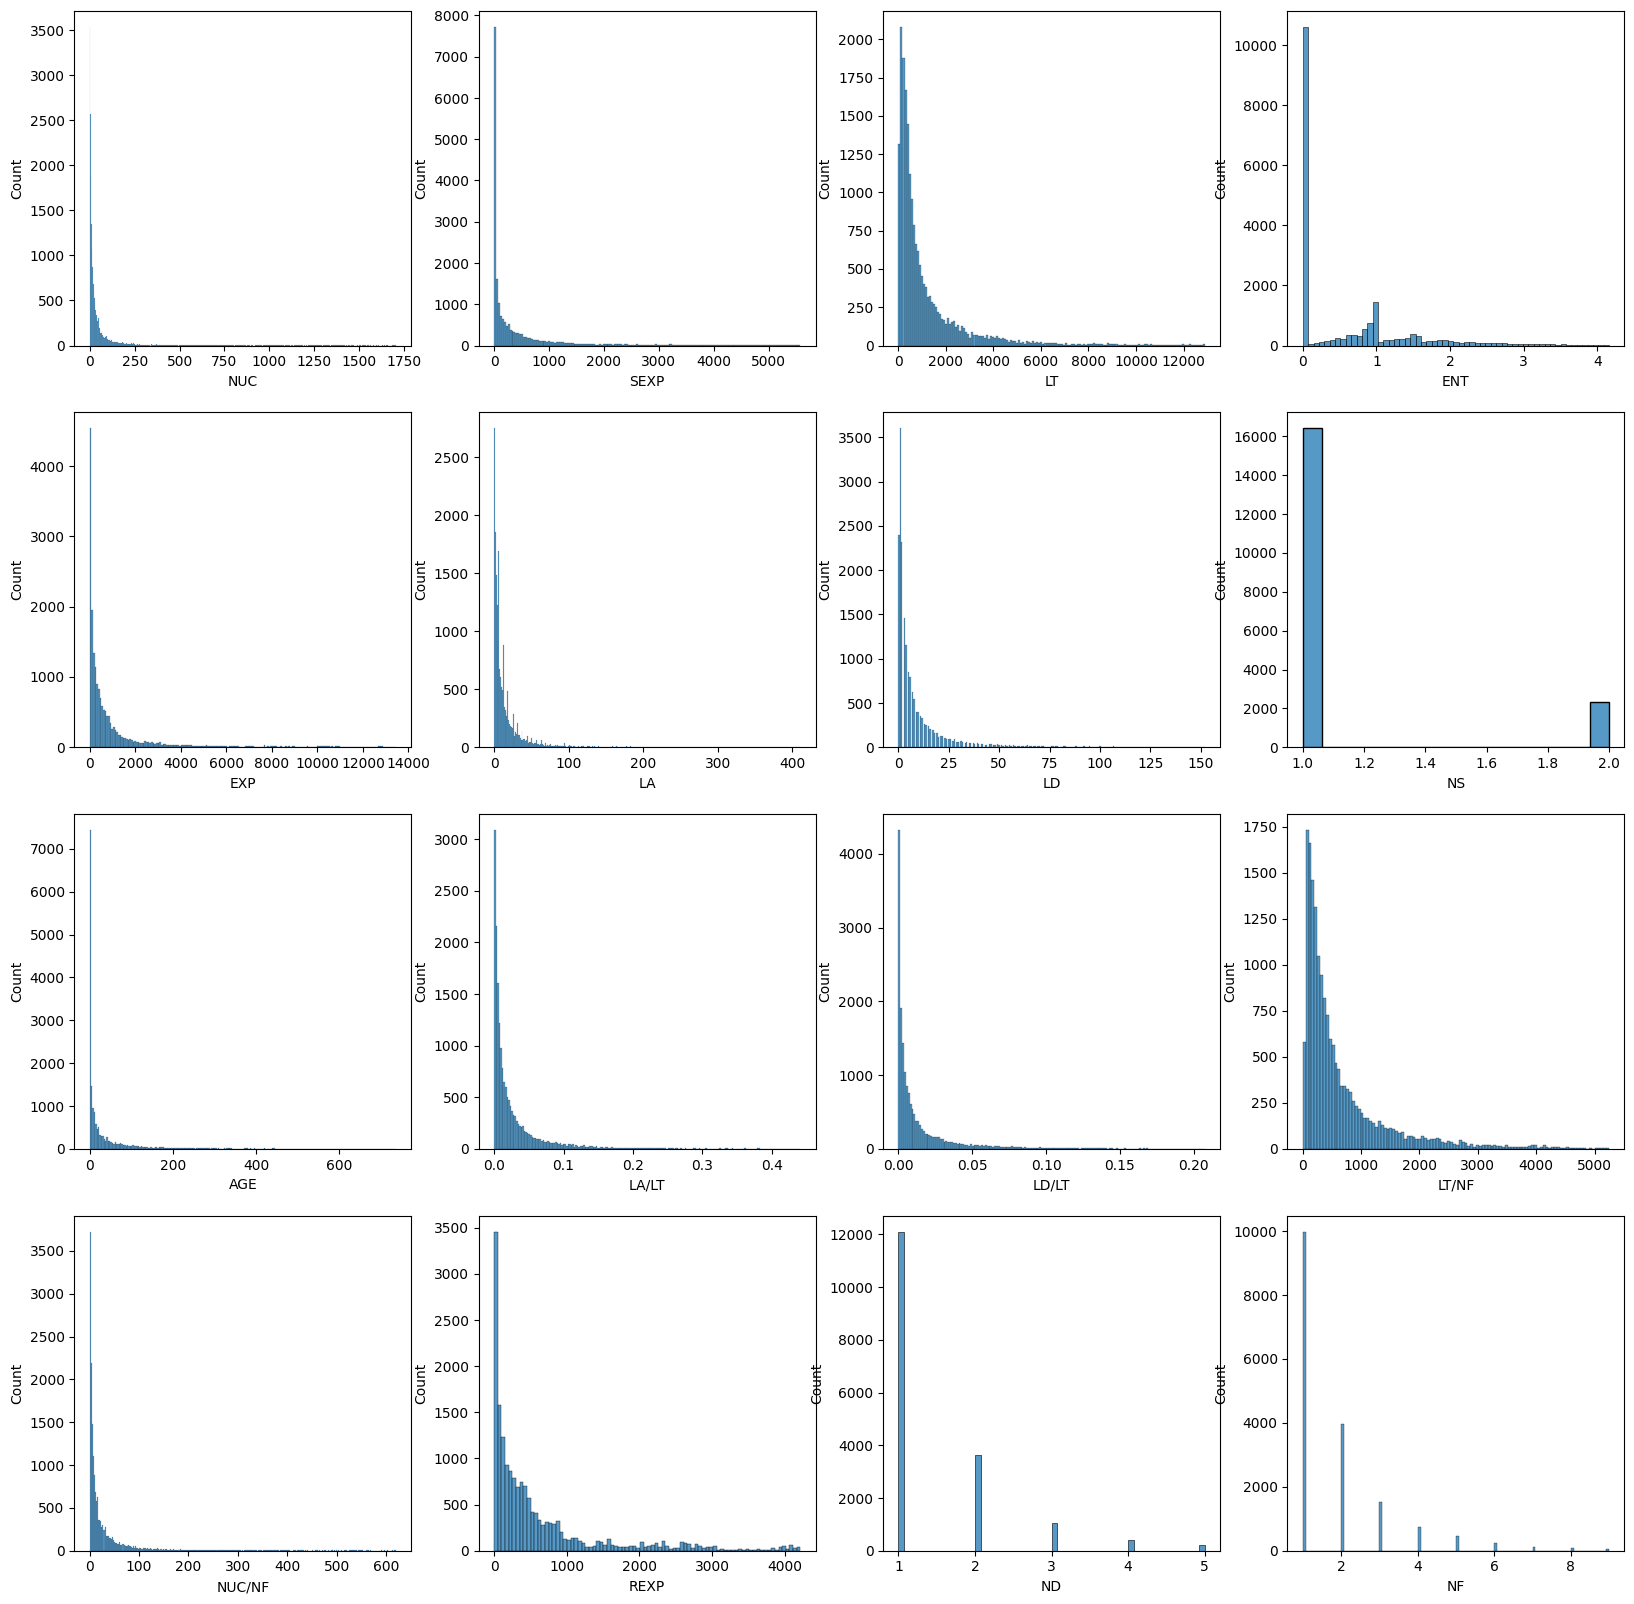

In [49]:
figura, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(BASE_ALL):
    # Remove outliers
    total = total[total[feature] < total[feature].quantile(0.99)]
    sns.histplot(total[feature], ax=axs[i // 4, i % 4])

In [13]:
from environment import (
    PROJECTS
)
import pandas as pd

for project in PROJECTS:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    # data.rename(columns={"ENT": "E", "V": "HV", "REC": "EC", "DD_V": "DD_HV", "ENT_V": "E_HV", "RG": "GV", "NP": "NOP", "NTM": "NOMT", "RII": "II"}, inplace=True)
    data.rename(columns={"E":"TE"}, inplace=True)
    data.to_csv(f"../data/dataset/filtered/{project}.csv")

In [14]:
for project in PROJECTS:
    data = pd.read_csv(f"../data/dataset/filtered/{project}.csv", index_col=0)
    print(data.columns)

Index(['project', 'buggy', 'date', 'repo', 'gap', 'LA', 'LD', 'NF', 'ND', 'NS',
       'Entropy', 'NDEV', 'AGE', 'NUC', 'EXP', 'REXP', 'SEXP', 'target', 'LT',
       'fix_date', 'HV', 'TE', 'DD', 'MDNL', 'NB', 'EC', 'NOP', 'NOGV', 'NOMT',
       'II', 'E_HV', 'DD_HV', 'TS', 'LA/LT', 'LD/LT', 'LT/NF', 'NUC/NF'],
      dtype='object')
Index(['project', 'buggy', 'date', 'repo', 'gap', 'LA', 'LD', 'NF', 'ND', 'NS',
       'Entropy', 'NDEV', 'AGE', 'NUC', 'EXP', 'REXP', 'SEXP', 'target', 'LT',
       'fix_date', 'HV', 'TE', 'DD', 'MDNL', 'NB', 'EC', 'NOP', 'NOGV', 'NOMT',
       'II', 'E_HV', 'DD_HV', 'TS', 'LA/LT', 'LD/LT', 'LT/NF', 'NUC/NF'],
      dtype='object')
Index(['project', 'buggy', 'date', 'repo', 'gap', 'LA', 'LD', 'NF', 'ND', 'NS',
       'Entropy', 'NDEV', 'AGE', 'NUC', 'EXP', 'REXP', 'SEXP', 'target', 'LT',
       'fix_date', 'HV', 'TE', 'DD', 'MDNL', 'NB', 'EC', 'NOP', 'NOGV', 'NOMT',
       'II', 'E_HV', 'DD_HV', 'TS', 'LA/LT', 'LD/LT', 'LT/NF', 'NUC/NF'],
      dtype='obje

findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Li

Linux Libertine:style=normal:variant=normal:weight=normal:stretch=normal:file=/Users/juhansae/Library/Fonts/LinLibertine\_R.ttf:size=10.0


findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Libertine' not found.
findfont: Font family 'Linux Li

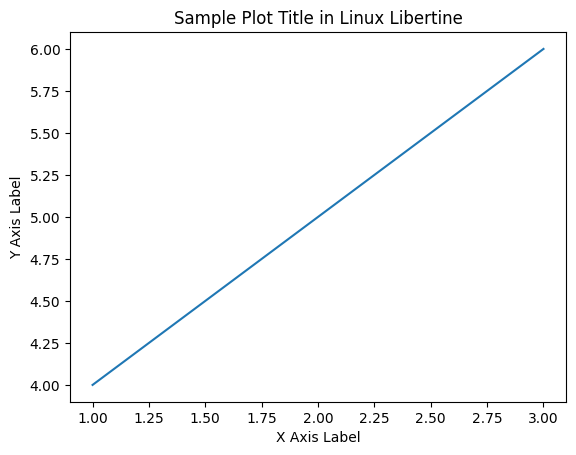

In [17]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/Users/juhansae/Library/Fonts/LinLibertine_R.ttf"
prop = fm.FontProperties(fname=font_path)
print(prop)
plt.rcParams['font.family'] = 'Linux Libertine O'

plt.figure()
plt.title('Sample Plot Title in Linux Libertine')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()